### Importaciones e inicio del cluster

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, dayofmonth, hour, minute
from pyspark.sql.functions import col
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Iniciar un cluster de Spark, de lo contrario crearlo
spark = SparkSession.builder \
    .appName("Accidentes Trafico") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()


### Limpieza y seleccion de los datos

In [3]:
# Ruta al archivo local
ruta = '../../data/US_Accidents_March23.csv'
accidentes = spark.read.csv(ruta, header=True, inferSchema=True)
accidentes.show(5)
accidentes.printSchema()

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

In [4]:
# Columnas a tratar
columnas = ['Severity', 'Start_Time', 'Start_Lng', 'Start_Lat', 'City', 
            'State', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
            'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)',
            'Weather_Condition']
# En pyspark se usa la funcion col() para crear el objeto fuera del schema
accidentes = accidentes.select([col(c) for c in columnas])
accidentes = accidentes.na.drop()

# Debemos separar la la columna Start_Time a valores numericos
# para que esta sea admitida por el modelo de ML.

# Spark tiene sus funciones correspondientes para lograr esto
accidentes = accidentes.withColumn("Year", year("Start_Time")) \
           .withColumn("Month", month("Start_Time")) \
           .withColumn("Day", dayofmonth("Start_Time")) \
           .withColumn("Hour", hour("Start_Time")) \
           .withColumn("Minute", minute("Start_Time"))
accidentes.show(5)

+--------+-------------------+------------------+------------------+------------+-----+--------------+-----------+------------+--------------+---------------+-----------------+-----------------+----+-----+---+----+------+
|Severity|         Start_Time|         Start_Lng|         Start_Lat|        City|State|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Year|Month|Day|Hour|Minute|
+--------+-------------------+------------------+------------------+------------+-----+--------------+-----------+------------+--------------+---------------+-----------------+-----------------+----+-----+---+----+------+
|       3|2016-02-08 07:44:26|-82.92519399999998|40.100590000000004| Westerville|   OH|          37.9|       97.0|       29.63|           7.0|            3.5|             0.03|       Light Rain|2016|    2|  8|   7|    44|
|       3|2016-02-08 08:10:04|-82.92519399999998|40.100590000000004| Westerville|   OH|          37.4|      100.

In [5]:
# StringIndexer() para darle valores numericos a la variable 'Weather_Condition', 
# luego aplicamos OneHotEncoder(); que convierte la categorizacion previa a forma binaria
weather_indexer = StringIndexer(inputCol="Weather_Condition", outputCol="Weather_Condition_Indexed")
weather_encoder = OneHotEncoder(inputCol="Weather_Condition_Indexed", outputCol="Weather_Condition_Encoded")

# Codificar City
city_indexer = StringIndexer(inputCol="City", outputCol="City_Indexed")
city_encoder = OneHotEncoder(inputCol="City_Indexed", outputCol="City_Encoded")

# Codificar State
state_indexer = StringIndexer(inputCol="State", outputCol="State_Indexed")
state_encoder = OneHotEncoder(inputCol="State_Indexed", outputCol="State_Encoded")

# VectorAssembler() fusiona varias columnas en un 'vector columna'
relevant_columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 
                    'Start_Lng', 'Start_Lat', 'City_Encoded', 
                    'State_Encoded', 'Temperature(F)', 'Humidity(%)', 
                    'Pressure(in)','Visibility(mi)', 'Wind_Speed(mph)', 
                    'Precipitation(in)', 'Weather_Condition_Encoded']
assembler = VectorAssembler(inputCols=relevant_columns, 
                            outputCol="features")

# Pipeline: indexer, encoder y assembler son clases (no se han ejecutado)
# se llamara a estas transformaciones desde un Pipeline
pipeline = Pipeline(stages=[
    city_indexer, city_encoder,
    state_indexer, state_encoder,
    weather_indexer, weather_encoder,
    assembler
])
model = pipeline.fit(accidentes)
transformed_data = model.transform(accidentes)

# Mostrar datos transformados
transformed_data.select("features", "Severity").show(5)

+--------------------+--------+
|            features|Severity|
+--------------------+--------+
|(12485,[0,1,2,3,4...|       3|
|(12485,[0,1,2,3,4...|       3|
|(12485,[0,1,2,3,4...|       3|
|(12485,[0,1,2,3,4...|       2|
|(12485,[0,1,2,3,4...|       2|
+--------------------+--------+
only showing top 5 rows



### Analisis incial

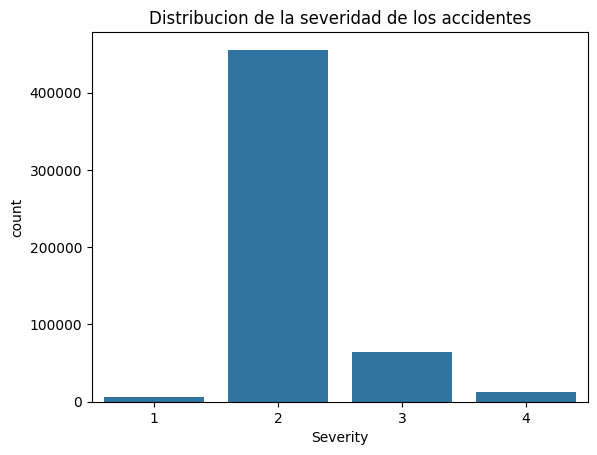

In [6]:

# Columnas relevantes para analisis de correlacion
relevant_columns = ['Year', 'Month', 'Day', 'Hour', 'Minute',
                    'Start_Lng', 'Start_Lat', 'City_Indexed', 
                    'State_Indexed', 'Temperature(F)', 'Humidity(%)', 
                    'Pressure(in)','Visibility(mi)', 'Wind_Speed(mph)',
                    'Precipitation(in)', 'Weather_Condition_Indexed']
# Muestra del 10% de los datos
sample_data = transformed_data.select(relevant_columns+['Severity'])\
    .sample(False, 0.1).toPandas()

# Distribucion de 'Severity'
sns.countplot(data=sample_data, x='Severity')
plt.title('Distribucion de la severidad de los accidentes')
plt.show()


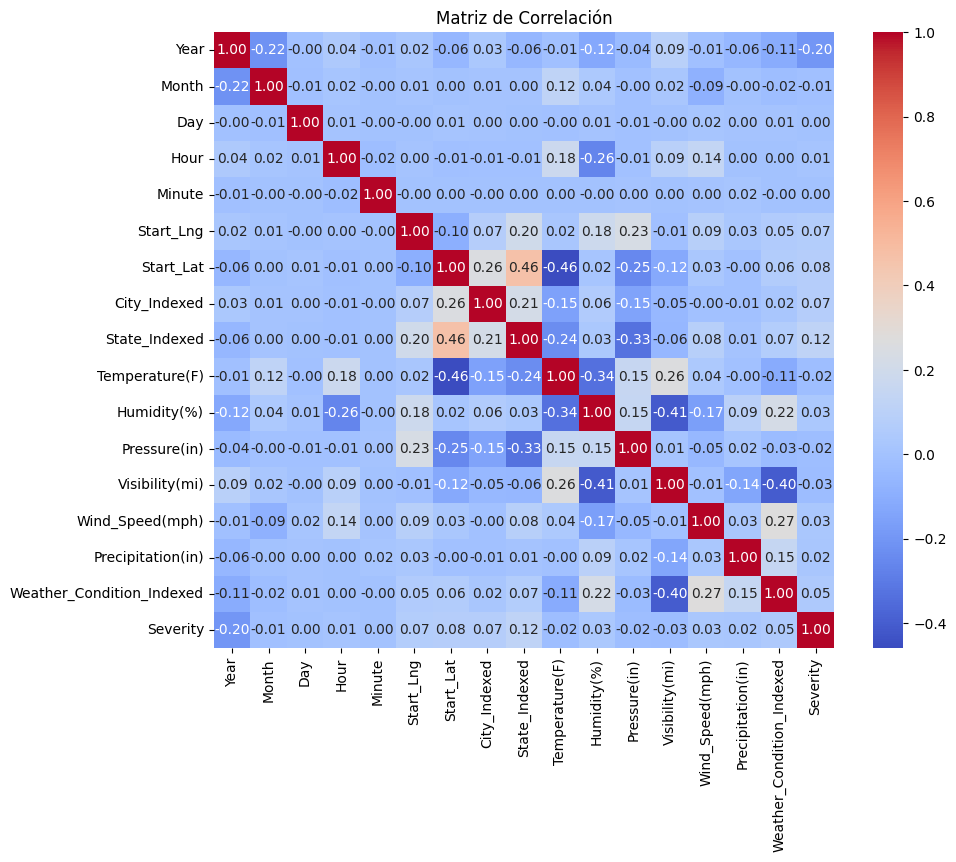

In [7]:
# Calcular la matriz de correlación (Pearson)
correlation_matrix = sample_data.corr()

# Definir el tamaño del plot en pulgadas
plt.figure(figsize=(10, 8))

# Crear el heatmap,
# annot=True : Permite ver los valores de la correlacion en las celdas
# cmap= : Define el juego de colores
# fmt='.2f' : Indica que los numeros en las celdas tendras 2 decimales
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

### Modelado predictivo

In [8]:
# Concretar el dataframe a utilizar
# Recordar que 'features' tiene colapsadas todas las variabes
data = transformed_data.select('features', 'Severity')
# Dividir los datos en entrenamiento (80%) y prueba (20%)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Escalado de caracteristicas
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(train_data)
train_data = scaler_model.transform(train_data).select('scaled_features', 'Severity')
test_data = scaler_model.transform(test_data).select('scaled_features', 'Severity')

In [9]:
# Eliminar RDDs/DataFrames innecesarios y liberar memoria
if 'transformed_data' in locals():
    transformed_data.unpersist()
    del transformed_data

del accidentes, data, sample_data

# Tomar una muestra del 1% para entrenar el modelo
# depende de la capacidad del equipo
sample_data = train_data.sample(fraction=0.01, seed=42)

# Entrenar el modelo con la muestra reducida
lr = LogisticRegression(featuresCol='scaled_features', labelCol='Severity')
lr_model = lr.fit(sample_data)



In [10]:
# Liberar memoria
del sample_data, train_data

# Evaluar el modelo
# Hacer predicciones en el conjunto de prueba
predictions = lr_model.transform(test_data)

# Mostrar las primeras predicciones
predictions.select("Severity", "prediction").show(5, truncate=False)
# Evaluador de precisión
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")

+--------+----------+
|Severity|prediction|
+--------+----------+
|2       |3.0       |
|2       |3.0       |
|2       |3.0       |
|3       |3.0       |
|3       |3.0       |
|3       |2.0       |
|3       |2.0       |
|2       |3.0       |
|2       |3.0       |
|2       |3.0       |
+--------+----------+
only showing top 10 rows

Accuracy: 0.8404
